# DBS-EEG-LFP Data Processing Pipeline

This notebook demonstrates the complete pipeline for processing and synchronizing DBS stimulation data from EEG and LFP recordings.

## Steps:
1. Load LFP data
2. Load EEG data  
3. Align LFP stimulation data
4. Synchronize EEG with LFP
5. Export to BIDS format
6. Visualization

In [1]:
import sys
from pathlib import Path
import os

project_root = Path(os.getcwd())
print(f"Current working directory: {project_root}")

Current working directory: /workspace


In [2]:
# Import modules
import sys
from pathlib import Path

# Add src directory to path
sys.path.append('/workspace/src')

# Import preprocessing modules
from preprocessing import lfp_io, eeg_io, alignment, bids_export, visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

print("✓ Modules loaded successfully")

✓ Modules loaded successfully


## 1. Configuration

In [3]:
# Define paths (use relative paths)
DATA_ROOT = project_root / 'shared' / 'data' / 'raw'
RESULTS_ROOT = project_root / 'shared' / 'results'
BIDS_ROOT = project_root / 'shared' / 'data' / 'bids_dataset'

# Subject information
SUBJECT_NAME = 'Roessner_Gerhard'
STIM_FREQ = 55  # Hz

subject_id ='001'
session_id='01'
task_name='StimOn55HzFull2'
diagnosis = 'PD'

# File paths
LFP_FILE = DATA_ROOT / SUBJECT_NAME / 'lfp' / 'brainsense_55Hz_2iter.json'
EEG_FILE = DATA_ROOT / SUBJECT_NAME / 'eeg' / 'Stim_On_55Hz_Full2.mff'
HEAD_MODEL = DATA_ROOT / SUBJECT_NAME / 'headmodel_ROESSNER.mat'
COORD_XML = EEG_FILE / 'coordinates.xml'

# Create output directories
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)
BIDS_ROOT.mkdir(parents=True, exist_ok=True)

print(f"Project root: {project_root}")
print(f"Data root: {DATA_ROOT}")
print(f"Results root: {RESULTS_ROOT}")
print(f"BIDS root: {BIDS_ROOT}")
print(f"Head Model file: {HEAD_MODEL}")
print(f"EEG Coordinates file: {COORD_XML}")


Project root: /workspace
Data root: /workspace/shared/data/raw
Results root: /workspace/shared/results
BIDS root: /workspace/shared/data/bids_dataset
Head Model file: /workspace/shared/data/raw/Roessner_Gerhard/headmodel_ROESSNER.mat
EEG Coordinates file: /workspace/shared/data/raw/Roessner_Gerhard/eeg/Stim_On_55Hz_Full2.mff/coordinates.xml


## 2. Load and Process LFP Data

In [4]:
# Load LFP data
print("Loading LFP data...")
df_ts_sense, df_ts_stim, df_settings = lfp_io.load_lfp_data(LFP_FILE)

print(f"\nLFP Sensing data shape: {df_ts_sense.shape}")
print(f"LFP Stimulation data shape: {df_ts_stim.shape}")
print(f"\nSettings:")
print(df_settings)

Loading LFP data...



LFP Sensing data shape: (29687, 2)
LFP Stimulation data shape: (236, 2)

Settings:
            subj_id  left_sr left_ch left_stim_contact  right_sr right_ch  \
0  Roessner_Gerhard      250    +3-0                 1       250     +3-0   

  right_stim_contact  
0                  1  


In [5]:
# Align stimulation data to sensing timeline
print("Aligning LFP stimulation data...")
df_ts_stim_aligned = lfp_io.align_stim_to_sense(df_ts_stim, df_ts_sense)

print(f"Aligned stimulation data shape: {df_ts_stim_aligned.shape}")
print(f"Duration: {(df_ts_sense.index[-1] - df_ts_sense.index[0]).total_seconds():.1f} seconds")

Aligning LFP stimulation data...
Aligned stimulation data shape: (29687, 2)
Duration: 118.7 seconds


In [6]:
# Extract middle segment for analysis
print("Extracting middle stimulation segment...")

df_left_middle, left_info = lfp_io.extract_middle_segment(
    df_ts_sense, 
    df_ts_stim_aligned, 
    side='left',
    start_buffer_sec=0,  
    end_buffer_sec=0     
)

if left_info:
    print(f"\nLeft hemisphere middle segment:")
    print(f"  Duration: {left_info['duration_sec']:.2f} seconds")
    print(f"  Samples: {left_info['n_samples']}")
    print(f"  Stim amplitude: {left_info['stim_amplitude']} mA")
    
    LFP_SEGMENT_DURATION = left_info['duration_sec']
else:
    print("Warning: Could not extract StimOn segment")


Extracting middle stimulation segment...
Removed 317 samples containing artifacts

Left hemisphere middle segment:
  Duration: 95.23 seconds
  Samples: 23808
  Stim amplitude: 3.0 mA


## 3. Load and Process EEG Data

In [14]:
# Load EEG data
print("Loading EEG data...")
raw = eeg_io.load_eeg_data(EEG_FILE, preload=True)

print(f"\nEEG info:")
print(f"  Channels: {len(raw.ch_names)}")
print(f"  Sampling rate: {raw.info['sfreq']} Hz")
print(f"  Duration: {raw.times[-1]:.1f} seconds")

Loading EEG data...
Reading EGI MFF Header from /workspace/shared/data/raw/Roessner_Gerhard/eeg/Stim_On_55Hz_Full2.mff...
    Reading events ...
    Assembling measurement info ...
    Excluding events {} ...
Reading 0 ... 56944  =      0.000 ...   113.888 secs...

EEG info:
  Channels: 281
  Sampling rate: 500.0 Hz
  Duration: 113.9 seconds


In [15]:
# Setup reference channels
print("Setting up reference channels...")
raw = eeg_io.setup_reference_channels(raw)

# Detect stimulation frequency
print("\nDetecting stimulation frequency...")
detected_freq, freqs, psd = eeg_io.detect_stim_frequency(raw, freq_range=(40, 70))

print(f"Detected frequency: {detected_freq:.2f} Hz")
print(f"Expected frequency: {STIM_FREQ} Hz")

Setting up reference channels...
Setting reference channels: ['REF CZ']

Detecting stimulation frequency...


/workspace/src/preprocessing/eeg_io.py:69: RuntimeWarning: The unit for channel(s) REF CZ has changed from V to NA.
  raw.set_channel_types(channel_types)


Detected frequency: 55.60 Hz
Expected frequency: 55 Hz


In [ ]:
# Import 3D electrode coordinates
montage, scale = eeg_io.apply_coordinates_xml(raw, COORD_XML, set_ref_misc=False, verbose=True)
print("Unit scale → meters:", scale)


Mapped 280 EEG channels from coordinates.xml to raw channels.
EEG coordinate ranges (meters): X -0.0868→0.0872, Y -0.1002→0.1020, Z -0.1903→0.0117
Unit scale → meters: 0.01


## 4. Synchronize EEG with LFP

In [17]:
# Perform synchronization
print("Synchronizing EEG with LFP...")
eeg_segment, sync_info = alignment.synchronize_eeg_lfp_simple(
    raw_eeg=raw,
    stim_freq=STIM_FREQ,
    lfp_duration=LFP_SEGMENT_DURATION
)

if eeg_segment is not None:
    print("\n" + "="*60)
    print("SYNCHRONIZATION SUMMARY")
    print("="*60)
    print(f"EEG duration: {sync_info['eeg_duration']:.2f}s")
    print(f"LFP duration: {sync_info['lfp_duration']:.2f}s")
    print(f"Difference: {sync_info['duration_diff']:.2f}s")
    print(f"EEG samples: {eeg_segment.n_times}")
else:
    print("\nSynchronization failed!")

Synchronizing EEG with LFP...

EEG-LFP SYNCHRONIZATION (Duration-based)

[1] Extracting 55 Hz power from EEG...
    Power range: 0.00 - 0.00

[2] Finding threshold to match LFP duration (95.2s)...

✅ Found optimal threshold: 0.900 (normalized)
    Segment: 10.1s - 105.5s
    Duration: 95.3s
    Difference from LFP: 0.10s

[3] Cropping EEG...

✅ SYNCHRONIZATION COMPLETE

SYNCHRONIZATION SUMMARY
EEG duration: 95.33s
LFP duration: 95.23s
Difference: 0.10s
EEG samples: 47666


## 5. Visualize Results

✓ Figure saved: /workspace/shared/results/lfp_timeseries.png


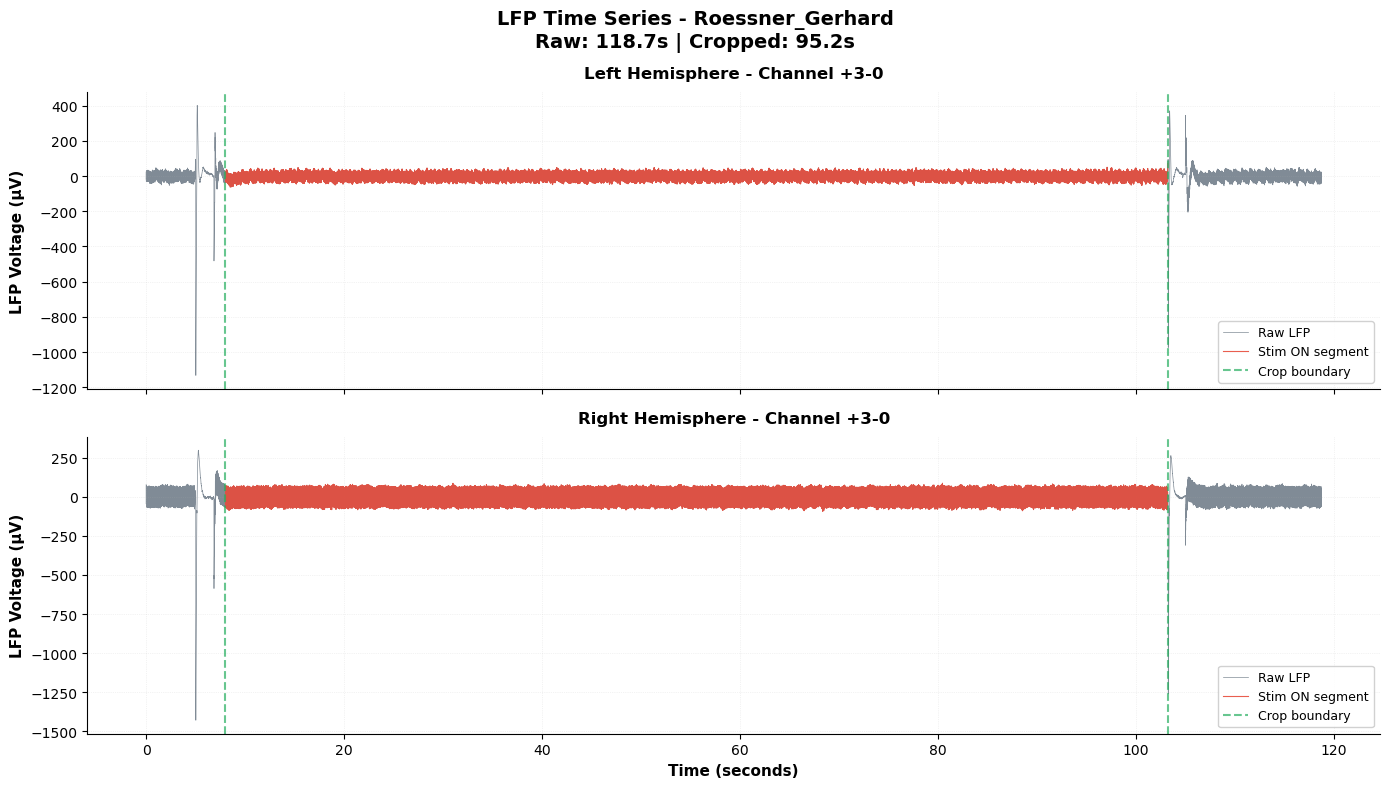

In [18]:
# from preprocessing import visualization

# LFP时间序列（显示原始+裁剪段）
fig = visualization.plot_lfp_timeseries(
    df_ts_sense=df_ts_sense,       # 完整原始数据
    df_ts_cropped=df_left_middle,  # 裁剪后的数据
    df_settings=df_settings,
    save_path=RESULTS_ROOT / 'lfp_timeseries.png'
)
plt.show()

✓ Figure saved: eeg_comparison.png


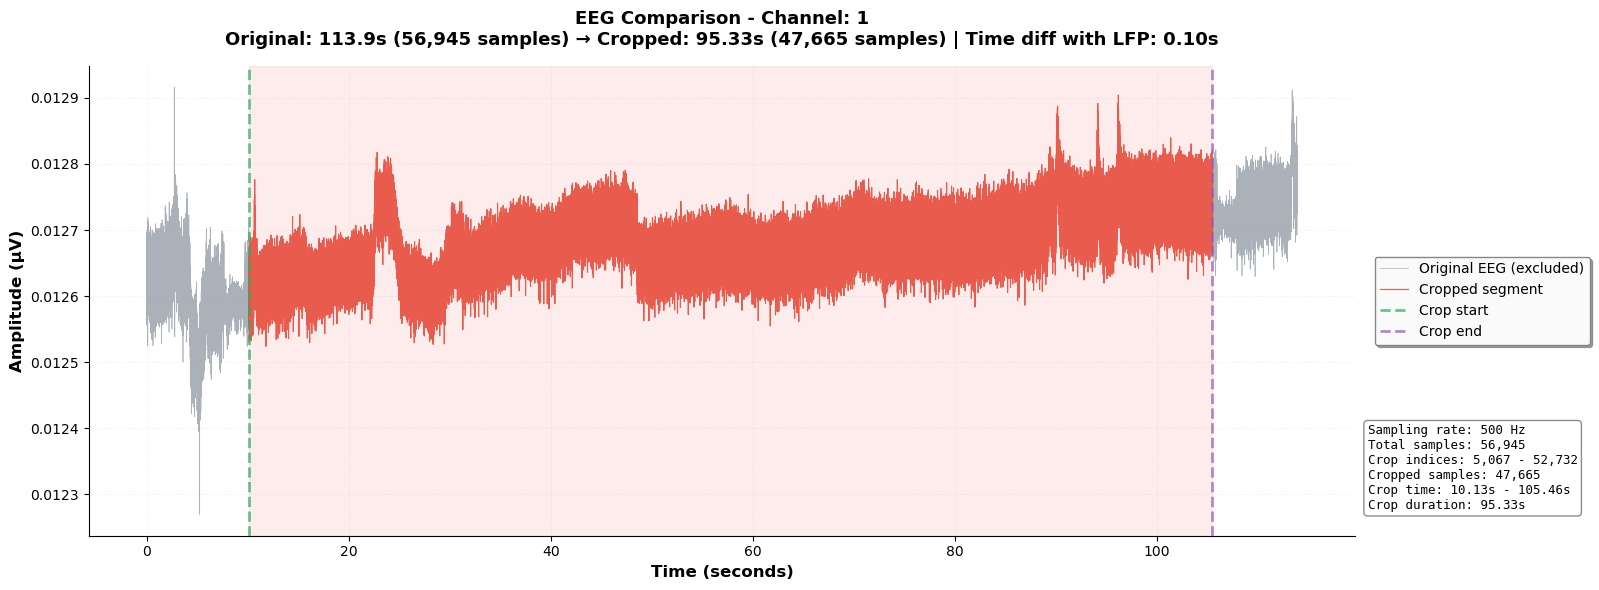

In [19]:
# 计算索引
eeg_start_time = sync_info.get('eeg_start')
eeg_end_time = sync_info.get('eeg_end')
sfreq = raw.info['sfreq']

crop_start_idx = int(eeg_start_time * sfreq)
crop_end_idx = int(eeg_end_time * sfreq)

# 调用可视化
fig = visualization.plot_eeg_comparison(
    raw_eeg=raw,
    crop_start_idx=crop_start_idx,
    crop_end_idx=crop_end_idx,
    channel_idx=0,
    sync_info=sync_info,
    save_path='eeg_comparison.png'
)

✓ Figure saved: /workspace/shared/results/stimulation_amplitudes.png


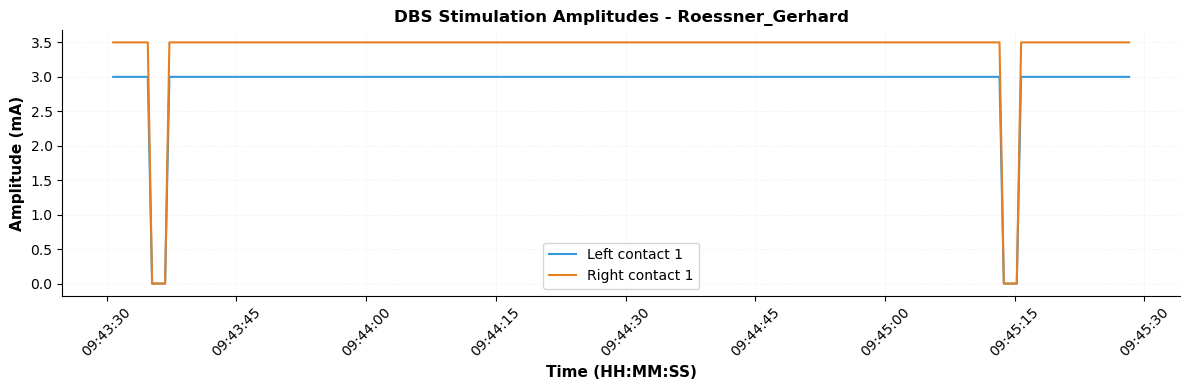

In [20]:
# Plot stimulation amplitudes
fig = visualization.plot_stimulation_amplitudes(
    df_ts_stim,
    df_settings,
    save_path=RESULTS_ROOT / 'stimulation_amplitudes.png'
)
plt.show()

✓ Figure saved: /workspace/shared/results/synchronization_result.png


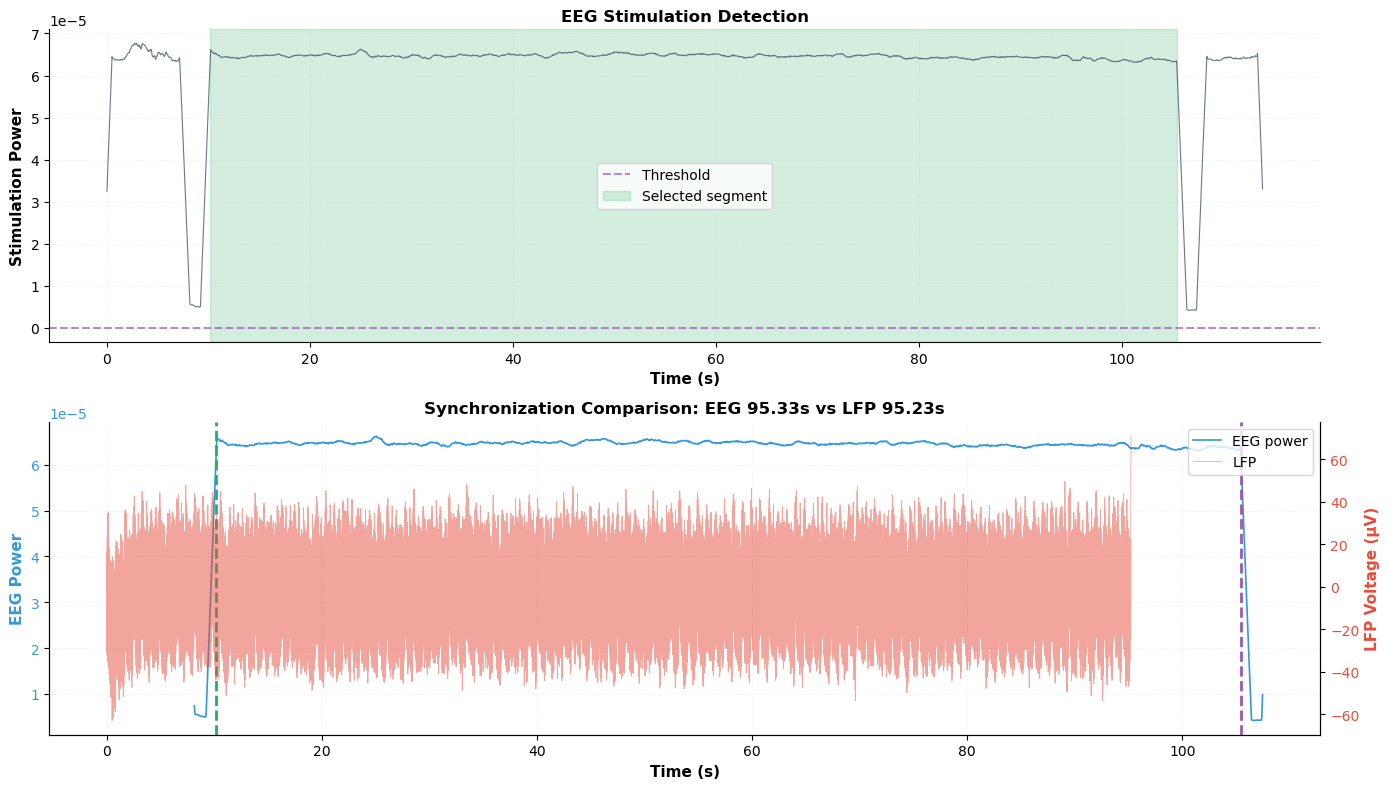

In [21]:
# Plot synchronization result
if sync_info is not None:
    fig = visualization.plot_synchronization_result(
        sync_info,
        df_lfp=df_left_middle if df_left_middle is not None else df_ts_sense,
        save_path=RESULTS_ROOT / 'synchronization_result.png'
    )
    plt.show()

## 6. Compute Power Spectral Density

Computing power spectral density...
✓ Figure saved: /workspace/shared/results/lfp_psd.png


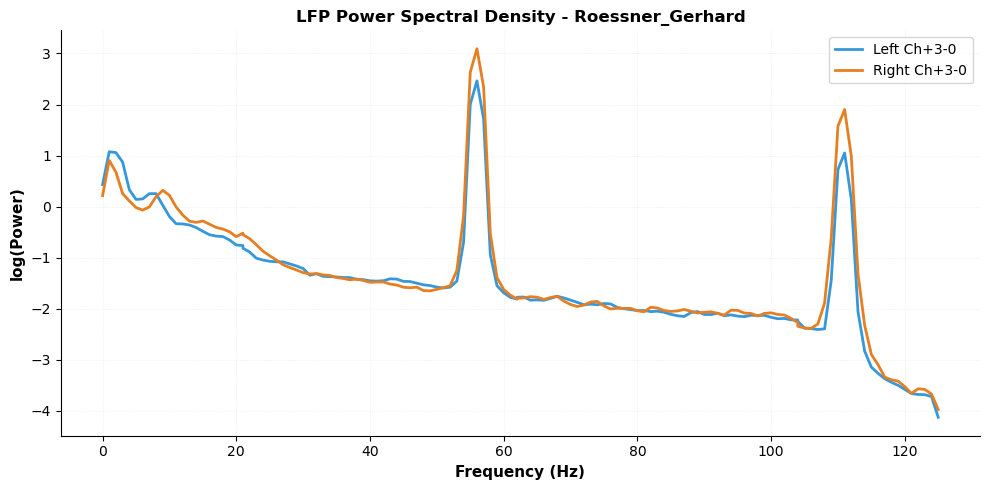

In [22]:
# Compute PSD for LFP
print("Computing power spectral density...")
df_psd = lfp_io.compute_psd(
    df_left_middle if df_left_middle is not None else df_ts_sense,
    df_settings
)

# Plot PSD
fig = visualization.plot_lfp_psd(
    df_psd,
    df_settings,
    save_path=RESULTS_ROOT / 'lfp_psd.png'
)
plt.show()

## 7. Export to BIDS Format

In [23]:
# Use the updated export script
if 'preprocessing.bids_export' in sys.modules:
    del sys.modules['preprocessing.bids_export']
    
from preprocessing.bids_export import export_to_bids


# Export with FIF format enabled
bids_root = export_to_bids(
    eeg_segment=eeg_segment,
    df_lfp_sense=df_left_middle if df_left_middle is not None else df_ts_sense,
    df_stim_aligned=df_ts_stim_aligned,
    df_settings=df_settings,
    subject_id=subject_id,
    session=session_id,
    task=task_name,
    bids_root=BIDS_ROOT,
    stim_freq=STIM_FREQ,
    diagnosis=diagnosis,
    save_lfp_fif=True,   # Save as FIF (for preprocessing)
    save_lfp_tsv=True    # Also save as TSV (for archival)
)




CREATING BIDS DATASET WITH DERIVATIVES

[STEP 1] Creating BIDS directory structure...
    OK Raw BIDS structure
    OK Derivatives structure

[STEP 2] Creating dataset-level metadata...
OK Dataset description: dataset_description.json
OK Derivatives description: derivatives/mne-python/dataset_description.json
OK Participants files: participants.tsv, participants.json

[STEP 3] Saving EEG data...

SAVING EEG DATA IN BIDS FORMAT

[1] Checking digitization information...
    Digitization points: 283
      - Fiducials: 3
      - EEG: 280

[2] Writing EEG data (BrainVision format - BIDS standard)...


/workspace/src/preprocessing/bids_export.py:143: RuntimeWarning: No events found or provided. Please add annotations to the raw data, or provide the events and event_id parameters. For resting state data, BIDS recommends naming the task using labels beginning with "rest".
  write_raw_bids(
/opt/conda/lib/python3.12/site-packages/mne_bids/write.py:1354: UserWarning: Conflicting BIDSVersion found in dataset_description.json! Consider setting BIDS root to a new directory and redo conversion after ensuring all software has been updated. Original dataset description will not be overwritten.
  warnings.warn(
/workspace/src/preprocessing/bids_export.py:143: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(
/opt/conda/lib/python3.12/site-packages/pybv/io.py:690: UserWarning: Encountered unsupported non-voltage units: n/a
Note that the BrainVision format specification supports only µV.
  warn(msg)


    OK EEG data saved to: sub-001/ses-01/eeg

[3] Saving FIF format in derivatives...
    OK Saved FIF: derivatives/mne-python/sub-001/ses-01/eeg/sub-001_ses-01_task-StimOn55HzFull2_eeg.fif
    OK Digitization preserved: 283 points
    OK Saved README: README.txt

[4] Verifying BIDS files...
    ! Could not verify: SubjectInfo does not support directly setting the key 'diagnosis'. 

[5] Adding custom metadata...
    OK Metadata updated

[STEP 4] Saving LFP data...

SAVING LFP DATA IN BIDS FORMAT (iEEG)

[1] Preparing LFP data arrays...
    OK Data shape: 23808 samples
    OK Sampling rate: 250.0 Hz
    OK Duration: 95.23 seconds

[2] Writing LFP data as MNE FIF format (derivatives)...
Creating RawArray with float64 data, n_channels=4, n_times=23808
    Range : 0 ... 23807 =      0.000 ...    95.228 secs
Ready.
    OK Saved FIF: derivatives/mne-python/sub-001/ses-01/ieeg/sub-001_ses-01_task-StimOn55HzFull2_ieeg.fif
    OK Format: MNE-Python FIF (binary, efficient)
    OK Channels: 4
   

/workspace/src/preprocessing/bids_export.py:198: RuntimeWarning: Did not find any events.tsv associated with sub-001_ses-01_task-StimOn55HzFull2.

The search_str was "/workspace/shared/data/bids_dataset/sub-001/**/eeg/sub-001_ses-01*events.tsv"
  raw_reloaded = read_raw_bids(bids_path, verbose=False)
/workspace/src/preprocessing/bids_export.py:198: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['REF CZ']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_reloaded = read_raw_bids(bids_path, verbose=False)


    OK Saved TSV: sub-001/ses-01/ieeg/sub-001_ses-01_task-StimOn55HzFull2_ieeg.tsv
    OK Format: TSV (text, human-readable)

[4] Writing metadata...
    OK Saved: sub-001_ses-01_task-StimOn55HzFull2_ieeg.json

[5] Writing channel information...
    OK Saved: sub-001_ses-01_task-StimOn55HzFull2_channels.tsv

[6] Writing stimulation events...
    OK Saved: sub-001_ses-01_task-StimOn55HzFull2_events.tsv

>> LFP data export complete!

SUCCESS - BIDS DATASET CREATED

Dataset location: /workspace/shared/data/bids_dataset

Structure:
  bids_dataset/
  ├── sub-001/ses-01/
  │   ├── eeg/     (BrainVision format)
  │   └── ieeg/    (TSV format + metadata)
  └── derivatives/mne-python/sub-001/ses-01/
      ├── eeg/     (FIF format with digitization)
      └── ieeg/    (FIF format for preprocessing)

>> FIF files ready for MNE-Python preprocessing pipeline
>> TSV files available for human inspection

>> Dataset is BIDS-compliant and ready for analysis!


## 8. Summary

In [25]:
print("\n" + "="*70)
print("PROCESSING COMPLETE")
print("="*70)
print(f"\nSubject: {SUBJECT_NAME}")
print(f"Stimulation frequency: {STIM_FREQ} Hz")
print(f"\nLFP data:")
print(f"  Duration: {LFP_SEGMENT_DURATION:.2f}s")
print(f"  Samples: {len(df_left_middle) if df_left_middle is not None else len(df_ts_sense)}")

if eeg_segment is not None:
    print(f"\nEEG data:")
    print(f"  Duration: {sync_info['eeg_duration']:.2f}s")
    print(f"  Samples: {eeg_segment.n_times}")
    print(f"  Channels: {len(eeg_segment.ch_names)}")

print(f"\nResults saved to: {RESULTS_ROOT}")
print(f"BIDS data saved to: {BIDS_ROOT}")
print("\n✓ All processing steps completed successfully!")


PROCESSING COMPLETE

Subject: Roessner_Gerhard
Stimulation frequency: 55 Hz

LFP data:
  Duration: 95.23s
  Samples: 23808

EEG data:
  Duration: 95.33s
  Samples: 47666
  Channels: 281

Results saved to: /workspace/shared/results
BIDS data saved to: /workspace/shared/data/bids_dataset

✓ All processing steps completed successfully!
